In [5]:
from tqdm import tqdm 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import medmnist 
from medmnist import INFO, Evaluator

from sklearn.metrics import confusion_matrix

In [6]:
#data_flag = 'pneumoniamnist'
data_flag = 'organamnist'
# data_flag = 'breatmnist'
download = 'True'

epochs = 20
BATCH_SIZE = 32
lr = 0.001
#num_workers = 2 # number of parallel processes for data preparation

info = INFO[data_flag]
task = info['task'] # multiclass
n_channels = info['n_channels'] # 3 channels
n_classes = len(info['label']) # 9 classes
class_names = info['label']
DataClass = getattr(medmnist, info['python_class'])

In [7]:
print(f"The number of classes is: {n_classes}, and the number of channels is: {n_channels}.")

The number of classes is: 11, and the number of channels is: 1.


In [8]:
class_names

{'0': 'bladder',
 '1': 'femur-left',
 '2': 'femur-right',
 '3': 'heart',
 '4': 'kidney-left',
 '5': 'kidney-right',
 '6': 'liver',
 '7': 'lung-left',
 '8': 'lung-right',
 '9': 'pancreas',
 '10': 'spleen'}

## Transformations

### RandomHorizontalFlip()
RandomHorizontalFlip() method of torchvision.transforms module is used to horizontally flip the given image at a random angle with a given probability. This method accepts a PIL and tensor image as input. The tensor imaged is a Pytorch tensor with shape [C, H, W], where C represents the number of channels and H,W represents the height and width respectively. This method returns a horizontally flipped image and an original image if the probability P is 1 or 0 respectively, if P in the range between 0 and 1 then P is the probability to return the horizontally flipeed image.

### GaussianBlur()
Blurs images with randomly chosen Gaussina blur. if the image is torch Tensor, it is expected to have [..., C, H, W] shape, where ... means an arbitary number of leading dimensions.

### RandomAdjustSharpness()
Adjust the sharpness of the image randomly with a given probability. If the image is torch Tensor, it is expected to have [..., 1 or 3, H, W] shape, where ... means an arbitary number of leading dimensions.

In [9]:
# preprocessing
data_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1,5)),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[.5])
])


# Load the data
train_dataset = DataClass(split ='train', transform = data_transform, download=download)
test_dataset = DataClass(split='test', transform = data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
train_loader_at_eval = data.DataLoader(dataset = train_dataset, batch_size = 2*BATCH_SIZE, shuffle = False)
test_loader = data.DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False)

Using downloaded and verified file: C:\Users\Theodora\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\Theodora\.medmnist\organamnist.npz


In [10]:
print(f"The number of the training images is: {len(train_dataset)} and the number of the test images is: {len(test_dataset)}")

The number of the training images is: 34581 and the number of the test images is: 17778


In [11]:
print(f"The batch size is {BATCH_SIZE} and the length of trainloader is: {len(train_loader)}")

The batch size is 32 and the length of trainloader is: 1081


In [12]:
print(train_loader.dataset[0][0].shape)

torch.Size([1, 224, 224])


In [13]:
print(train_dataset)
print('='*50)
print(test_dataset)

Dataset OrganAMNIST (organamnist)
    Number of datapoints: 34581
    Root location: C:\Users\Theodora\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34581, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to perform multi-cl

In [14]:
# Visualization
train_dataset.montage(length=1)

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


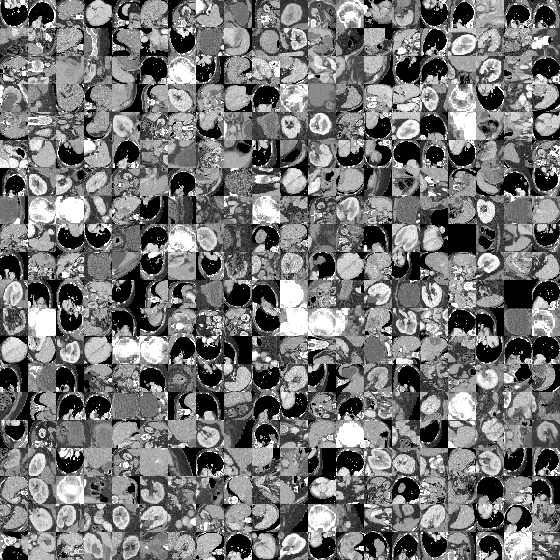

In [15]:
# montage
train_dataset.montage(length=20)

In [16]:
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_classes, p):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size = 3, stride = 1, padding = 1), # input size = 224, conv2d = 224, conv2d = 28, maxpool2d = 112
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        #nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        
        self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),   # input size = 112, conv2d = 112, conv2d = 112, maxpool = 56
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size = 3, stride =1, padding=1),
        nn.ReLU(),
        #nn.BatchNorm2d
        nn.Dropout(p),
        nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding=1), # input size = 56, conv2d = 56, conv2d = 56, maxpool = 28
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size = 3, stride =1, padding = 1),
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(256*28*28, 240),
        nn.ReLU(),
        nn.Dropout(p),
        nn.Linear(240, num_classes)
        )
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fc(x)
        return(x)
        



In [17]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0.0
    counter = 0
    for i, (image, labels) in tqdm(enumerate(trainloader), total = len(trainloader)):
        counter += 1
        #image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(image)
        
        # Calculate the loss
        if task == 'multi-label, binary-class':
            labels = labels.to(torch.float32)
            loss = criterion(outputs, labels)
        else:
            labels = labels.squeeze().long()
            loss = criterion(outputs, labels)
            
        train_running_loss += loss.item()
        # Calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds==labels).sum().item()
        # Backpropagation
        loss.backward()
        #Update teh weights
        optimizer.step()
        
    # Loss and accuracy for the complete epoch
    epoch_loss = train_running_loss/counter
    epoch_acc = 100.*(train_running_correct/ len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [18]:
if __name__ == '__main__':
    # Criterion
    if task == 'multi-label, binary-class':
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()
    
        
    # model selection
    model = ConvNet(n_channels, n_classes, p=0.5)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Loss function
    optimizer = optim.SGD(model.parameters(), lr, momentum = 0.9)
    
    # Lists to keep track of losses and accuracies
    train_loss = []
    train_acc = []
    # Starting the training
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                                optimizer, criterion)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)
        
        print(f"Training Loss: {train_epoch_loss:.3f}, training_acc: {train_epoch_acc:.3f}")
        print ('='*50)


[INFO]: Epoch 1 of 20
Training


100%|██████████| 1081/1081 [06:11<00:00,  2.91it/s]


Training Loss: 1.015, training_acc: 64.819
[INFO]: Epoch 2 of 20
Training


100%|██████████| 1081/1081 [06:08<00:00,  2.93it/s]


Training Loss: 0.466, training_acc: 84.147
[INFO]: Epoch 3 of 20
Training


100%|██████████| 1081/1081 [06:09<00:00,  2.93it/s]


Training Loss: 0.296, training_acc: 89.757
[INFO]: Epoch 4 of 20
Training


100%|██████████| 1081/1081 [06:09<00:00,  2.93it/s]


Training Loss: 0.209, training_acc: 92.837
[INFO]: Epoch 5 of 20
Training


100%|██████████| 1081/1081 [06:09<00:00,  2.93it/s]


Training Loss: 0.158, training_acc: 94.595
[INFO]: Epoch 6 of 20
Training


100%|██████████| 1081/1081 [06:08<00:00,  2.93it/s]


Training Loss: 0.120, training_acc: 95.778
[INFO]: Epoch 7 of 20
Training


100%|██████████| 1081/1081 [06:09<00:00,  2.93it/s]


Training Loss: 0.093, training_acc: 96.727
[INFO]: Epoch 8 of 20
Training


100%|██████████| 1081/1081 [06:09<00:00,  2.93it/s]


Training Loss: 0.082, training_acc: 97.253
[INFO]: Epoch 9 of 20
Training


100%|██████████| 1081/1081 [06:09<00:00,  2.93it/s]


Training Loss: 0.066, training_acc: 97.721
[INFO]: Epoch 10 of 20
Training


100%|██████████| 1081/1081 [06:08<00:00,  2.93it/s]


Training Loss: 0.054, training_acc: 98.048
[INFO]: Epoch 11 of 20
Training


100%|██████████| 1081/1081 [06:07<00:00,  2.94it/s]


Training Loss: 0.052, training_acc: 98.135
[INFO]: Epoch 12 of 20
Training


100%|██████████| 1081/1081 [06:08<00:00,  2.93it/s]


Training Loss: 0.045, training_acc: 98.384
[INFO]: Epoch 13 of 20
Training


100%|██████████| 1081/1081 [06:09<00:00,  2.93it/s]


Training Loss: 0.039, training_acc: 98.629
[INFO]: Epoch 14 of 20
Training


100%|██████████| 1081/1081 [06:08<00:00,  2.93it/s]


Training Loss: 0.036, training_acc: 98.762
[INFO]: Epoch 15 of 20
Training


100%|██████████| 1081/1081 [06:09<00:00,  2.93it/s]


Training Loss: 0.035, training_acc: 98.840
[INFO]: Epoch 16 of 20
Training


100%|██████████| 1081/1081 [06:08<00:00,  2.93it/s]


Training Loss: 0.031, training_acc: 98.892
[INFO]: Epoch 17 of 20
Training


100%|██████████| 1081/1081 [06:09<00:00,  2.93it/s]


Training Loss: 0.030, training_acc: 98.988
[INFO]: Epoch 18 of 20
Training


100%|██████████| 1081/1081 [06:08<00:00,  2.93it/s]


Training Loss: 0.028, training_acc: 99.063
[INFO]: Epoch 19 of 20
Training


100%|██████████| 1081/1081 [06:08<00:00,  2.94it/s]


Training Loss: 0.023, training_acc: 99.170
[INFO]: Epoch 20 of 20
Training


100%|██████████| 1081/1081 [06:08<00:00,  2.93it/s]

Training Loss: 0.021, training_acc: 99.231


In [46]:
def save_test_results(tensor, labels, output_class, counter):
    '''
    This function will save a few test images along with the
    ground truth label and predicted label annotated on the image
    
    :param tensor: the image tensor
    :param target: the ground truth class
    param output_class: the predicted class number
    param counter: the test image number
    '''
    
    # Move tensor to cpu and denormalize
    image = torch.squeeze(tensor, 0).cpu().numpy()
    image = image/2 + 0.5
    image = np.transpose(image, (1,2,0))
    # Convert to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    gt = labels.cpu().numpy()
    cv2.putText(
    image, f"GT: {gt}",
    (5,25), cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(
    image, f"Pred: {output_class}",
    (5, 55), cv2.FONT_HERSHEY_SIMPLEX, 
    0.7, (0,255,0), 2, cv2.LINE_AA)
    
    cv2.imwrite(f"../outputs/test_image_{counter}.png", image*255.)

In [47]:
def test(model, testloader):
    model.eval()
    print('Testing the model')
    prediction_list=[]
    ground_truth_list=[]
    test_running_correct=0
    counter=0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total = len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(image)
            # softmax probabilities
            predictions = F.softmax(outputs).cpu().numpy()
            # Predicted class number
            output_class = np.argmax(predictions)
            # Append the GT and predictions to the respective lists
            prediction_list.append(output_class)
            ground_truth_list.append(labels.squeeze().long().cpu().numpy())
            # Calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds==labels.squeeze().long()).sum().item()
            # Save a few test images.
            if counter % 999 == 0:
                save_test_results(image, labels, output_class, counter)
        acc = 100. * (test_running_correct / len(testloader.dataset))
        return prediction_list, ground_truth_list, acc

In [48]:
if __name__ == '__main__':
    
    prediction_list, ground_truth_list, acc = test(model, test_loader)
    print(f"Test accuracy: {acc:.3f}%")
    # Confusion matrix
    conf_matrix = confusion_matrix(ground_truth_list, prediction_list)
    
    plt.figure(figsize=(12,9))

    sns.heatmap(
    conf_matrix, 
    annot = True,
    xticklabels = class_names,
    yticklabels = class_names)
    
    plt.savefig('../outputs/heatmaps2.png')
    plt.close()


Testing the model


  0%|          | 0/17778 [00:00<?, ?it/s]<ipython-input-47-8c7b943596af>:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = F.softmax(outputs).cpu().numpy()
100%|██████████| 17778/17778 [02:40<00:00, 110.65it/s]


Test accuracy: 86.590%
